In [ ]:
from __future__ import annotations

import dataclasses
import json
import pathlib
import threading
import time

import const
import cv2
import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import tqdm
import utils

In [ ]:
def to_displayable(img, converted: int | None = cv2.COLOR_BGR2RGB) -> PIL.Image.Image:
    if converted is not None:
        img = cv2.cvtColor(img, converted)
    return PIL.Image.fromarray(np.clip(img.astype(np.uint8), 0, 255))


def showarray(img, converted: int | None = cv2.COLOR_BGR2RGB) -> None:
    display(to_displayable(img, converted))

In [ ]:
WIDTH, HEIGHT = 640, 480

In [ ]:
vid = "sun14"
src_frames = utils.read_video(const.VIDEOS_DIR / f"{vid}.mp4")
src_frames.array = utils.crop_vid_to_size(src_frames.array, WIDTH, HEIGHT)
align_meta = json.loads((const.META_DIR / f"match-{vid}.json").read_text())
homographies = np.array(align_meta["homographies"])
debug_masks = utils.make_horiz_masks(len(homographies), WIDTH, height=HEIGHT)

Reading c:\Extra\Masters\event-sun-effects-remover\data-prep\videos\sun14.mp4: 100%|██████████| 1129/1129 [00:05<00:00, 195.92it/s]


In [ ]:
import rpg_e2vid.utils.inference_utils as iu
import rpg_e2vid.utils.loading_utils as lu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = lu.load_model(const.PRETRAINED_DIR / "E2VID_lightweight.pth.tar").to(device)
events = utils.EventsData.from_path(f"./parsed/{vid}.bin")
_, ts_counts = np.unique(events.array[:, 0], return_counts=True)

c:\Users\njytwf\AppData\Local\anaconda3\envs\masters\lib\site-packages\rpg_e2vid\utils\loading_utils.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw_model = torch.lo

Using TransposedConvLayer (fast, with checkerboard artefacts)


In [ ]:
window_length = 50
event_it = utils.EventWindowIterator(
    events.array, ts_counts, window_length, stride=window_length
)
prev = None
rec_frames = []
for window in tqdm.tqdm(event_it, total=len(event_it)):
    vg = iu.events_to_voxel_grid(window, 5, WIDTH, HEIGHT)
    vg = torch.from_numpy(vg).unsqueeze(0).float().to(const.DEVICE)
    with torch.no_grad():
        pred, prev = model(vg, prev)
        pred = (pred.squeeze().cpu().numpy() * 255).astype(np.uint8)
        pred = cv2.undistort(pred, const.EVENT_MTX, const.EVENT_DIST)
        # sharpen
        pred_gb = cv2.GaussianBlur(pred, (0, 0), 3)
        pred = cv2.addWeighted(pred, 1.5, pred_gb, -0.5, 0)
        rec_frames.append(pred)

rec_frames = np.array(rec_frames)

  0%|          | 0/788 [00:00<?, ?it/s]

100%|██████████| 788/788 [01:33<00:00,  8.46it/s]


In [ ]:
rec_ts = np.arange(0, len(rec_frames) * window_length, window_length)

src_skip = 60
if True:
    src_frames.array = src_frames.array[src_skip:]
    skipped_src_ts = src_frames.timestamps[:src_skip]
    src_offset = src_frames.timestamps[src_skip]
    skipped_src_frames = src_frames.timestamps[:src_skip]
    src_frames.timestamps = src_frames.timestamps[src_skip:] - src_offset

In [ ]:
class BFNNMatcherWrapper:
    def __init__(self, threshold: float) -> None:
        self.matcher = cv2.BFMatcher()
        self.threshold = threshold

    def match(self, des1, des2):
        matches = self.matcher.knnMatch(des1, des2, k=2)
        good_matches = []
        for m, n in matches:
            if m.distance < self.threshold * n.distance:
                good_matches.append(m)
        return good_matches


class FlannMatcherWrapper:
    def __init__(self):
        self.matcher = cv2.FlannBasedMatcher.create()

    def match(self, des1, des2):
        return self.matcher.match(des1, des2)


class FlannNNMatcherWrapper:
    def __init__(self, threshold: float):
        self.matcher = cv2.FlannBasedMatcher.create()
        self.threshold = threshold

    def match(self, des1, des2):
        matches = self.matcher.knnMatch(des1, des2, k=2)
        good_matches = []
        for m, n in matches:
            if m.distance < self.threshold * n.distance:
                good_matches.append(m)
        return good_matches


feature_extractors = {
    "orb": cv2.ORB.create(),
    "sift": cv2.SIFT.create(),
    "asift": cv2.AffineFeature.create(cv2.SIFT.create()),
}
matchers = {
    "bf_hamming": cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True),
    "bf_l2": cv2.BFMatcher(cv2.NORM_L2, crossCheck=True),
    "bf_nn_50": BFNNMatcherWrapper(0.5),
    "bf_nn_70": BFNNMatcherWrapper(0.7),
    "bf_nn_90": BFNNMatcherWrapper(0.9),
    "flann": FlannMatcherWrapper(),
    "flann_nn_50": FlannNNMatcherWrapper(0.5),
    "flann_nn_70": FlannNNMatcherWrapper(0.7),
    "flann_nn_90": FlannNNMatcherWrapper(0.9),
}

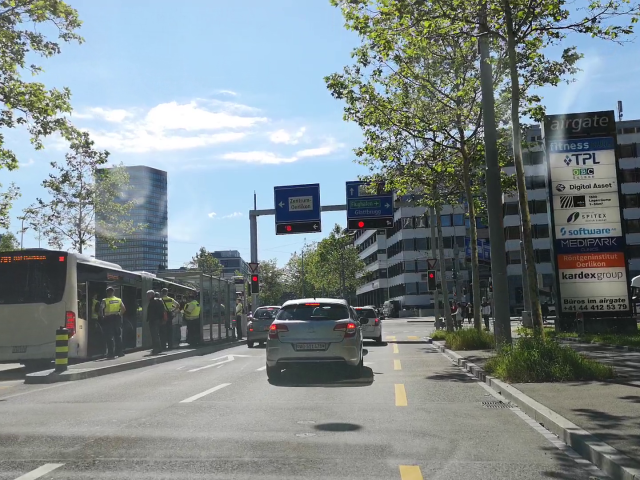

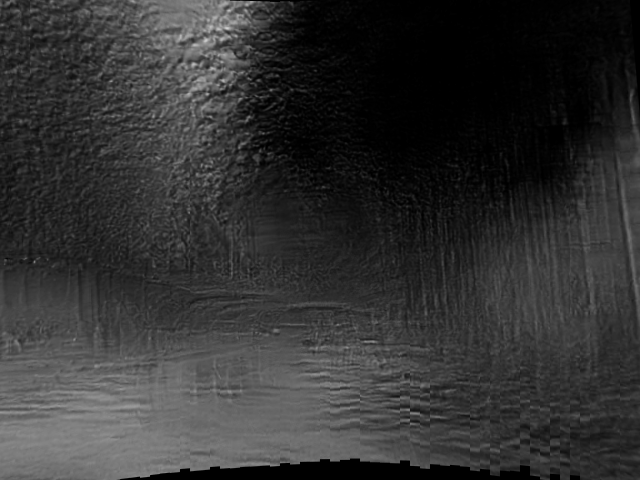

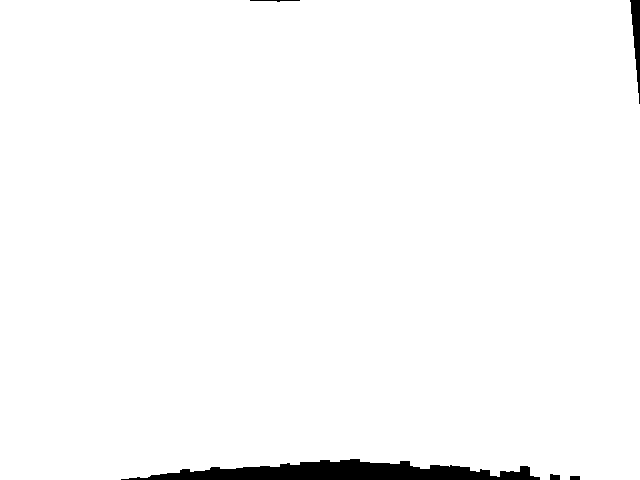

In [ ]:
img = np.load("../data/uzh/processed/street2_00500.npy")

showarray(img[:, :, :3])
showarray(img[:, :, 3])
showarray(img[:, :, 4])

In [ ]:
result = {}
for fe_name, feature_extractor in feature_extractors.items():
    descriptors = {}
    for offset in tqdm.tqdm(range(100), desc=fe_name):
        for i in range(0, len(src_frames.array), 50):
            src_frame = src_frames.array[i]
            src_frame_ts = src_frames.timestamps[i]
            aligned_rec_ts = offset * window_length + src_frames.timestamps[i]
            rec_idx = np.argmin(np.abs(rec_ts - aligned_rec_ts))
            rec_frame = rec_frames[rec_idx]
            src_frame_gs = cv2.cvtColor(src_frame, cv2.COLOR_BGR2GRAY)
            src_kp, src_desc = feature_extractor.detectAndCompute(src_frame_gs, None)
            rec_kp, rec_desc = feature_extractor.detectAndCompute(rec_frame, None)
            descriptors[(offset, i)] = (src_desc, rec_desc)

    for matcher_name, matcher in matchers.items():
        all_matches = []
        for offset in tqdm.tqdm(range(100), desc=f"{fe_name} {matcher_name}"):
            offset_matches = []
            for i in range(0, len(src_frames.array), 50):
                src_desc, rec_desc = descriptors[(offset, i)]
                if "flann" in matcher_name:
                    src_desc = np.float32(src_desc)
                    rec_desc = np.float32(rec_desc)
                elif "hamming" in matcher_name:
                    src_desc = np.uint8(src_desc)
                    rec_desc = np.uint8(rec_desc)
                matches = matcher.match(src_desc, rec_desc)
                num_matches = len(matches)
                offset_matches.append(num_matches)
            all_matches.append(offset_matches)
        result[(fe_name, matcher_name)] = all_matches

asift bf_l2:  35%|███▌      | 35/100 [11:54<22:06, 20.41s/it]


KeyboardInterrupt: 

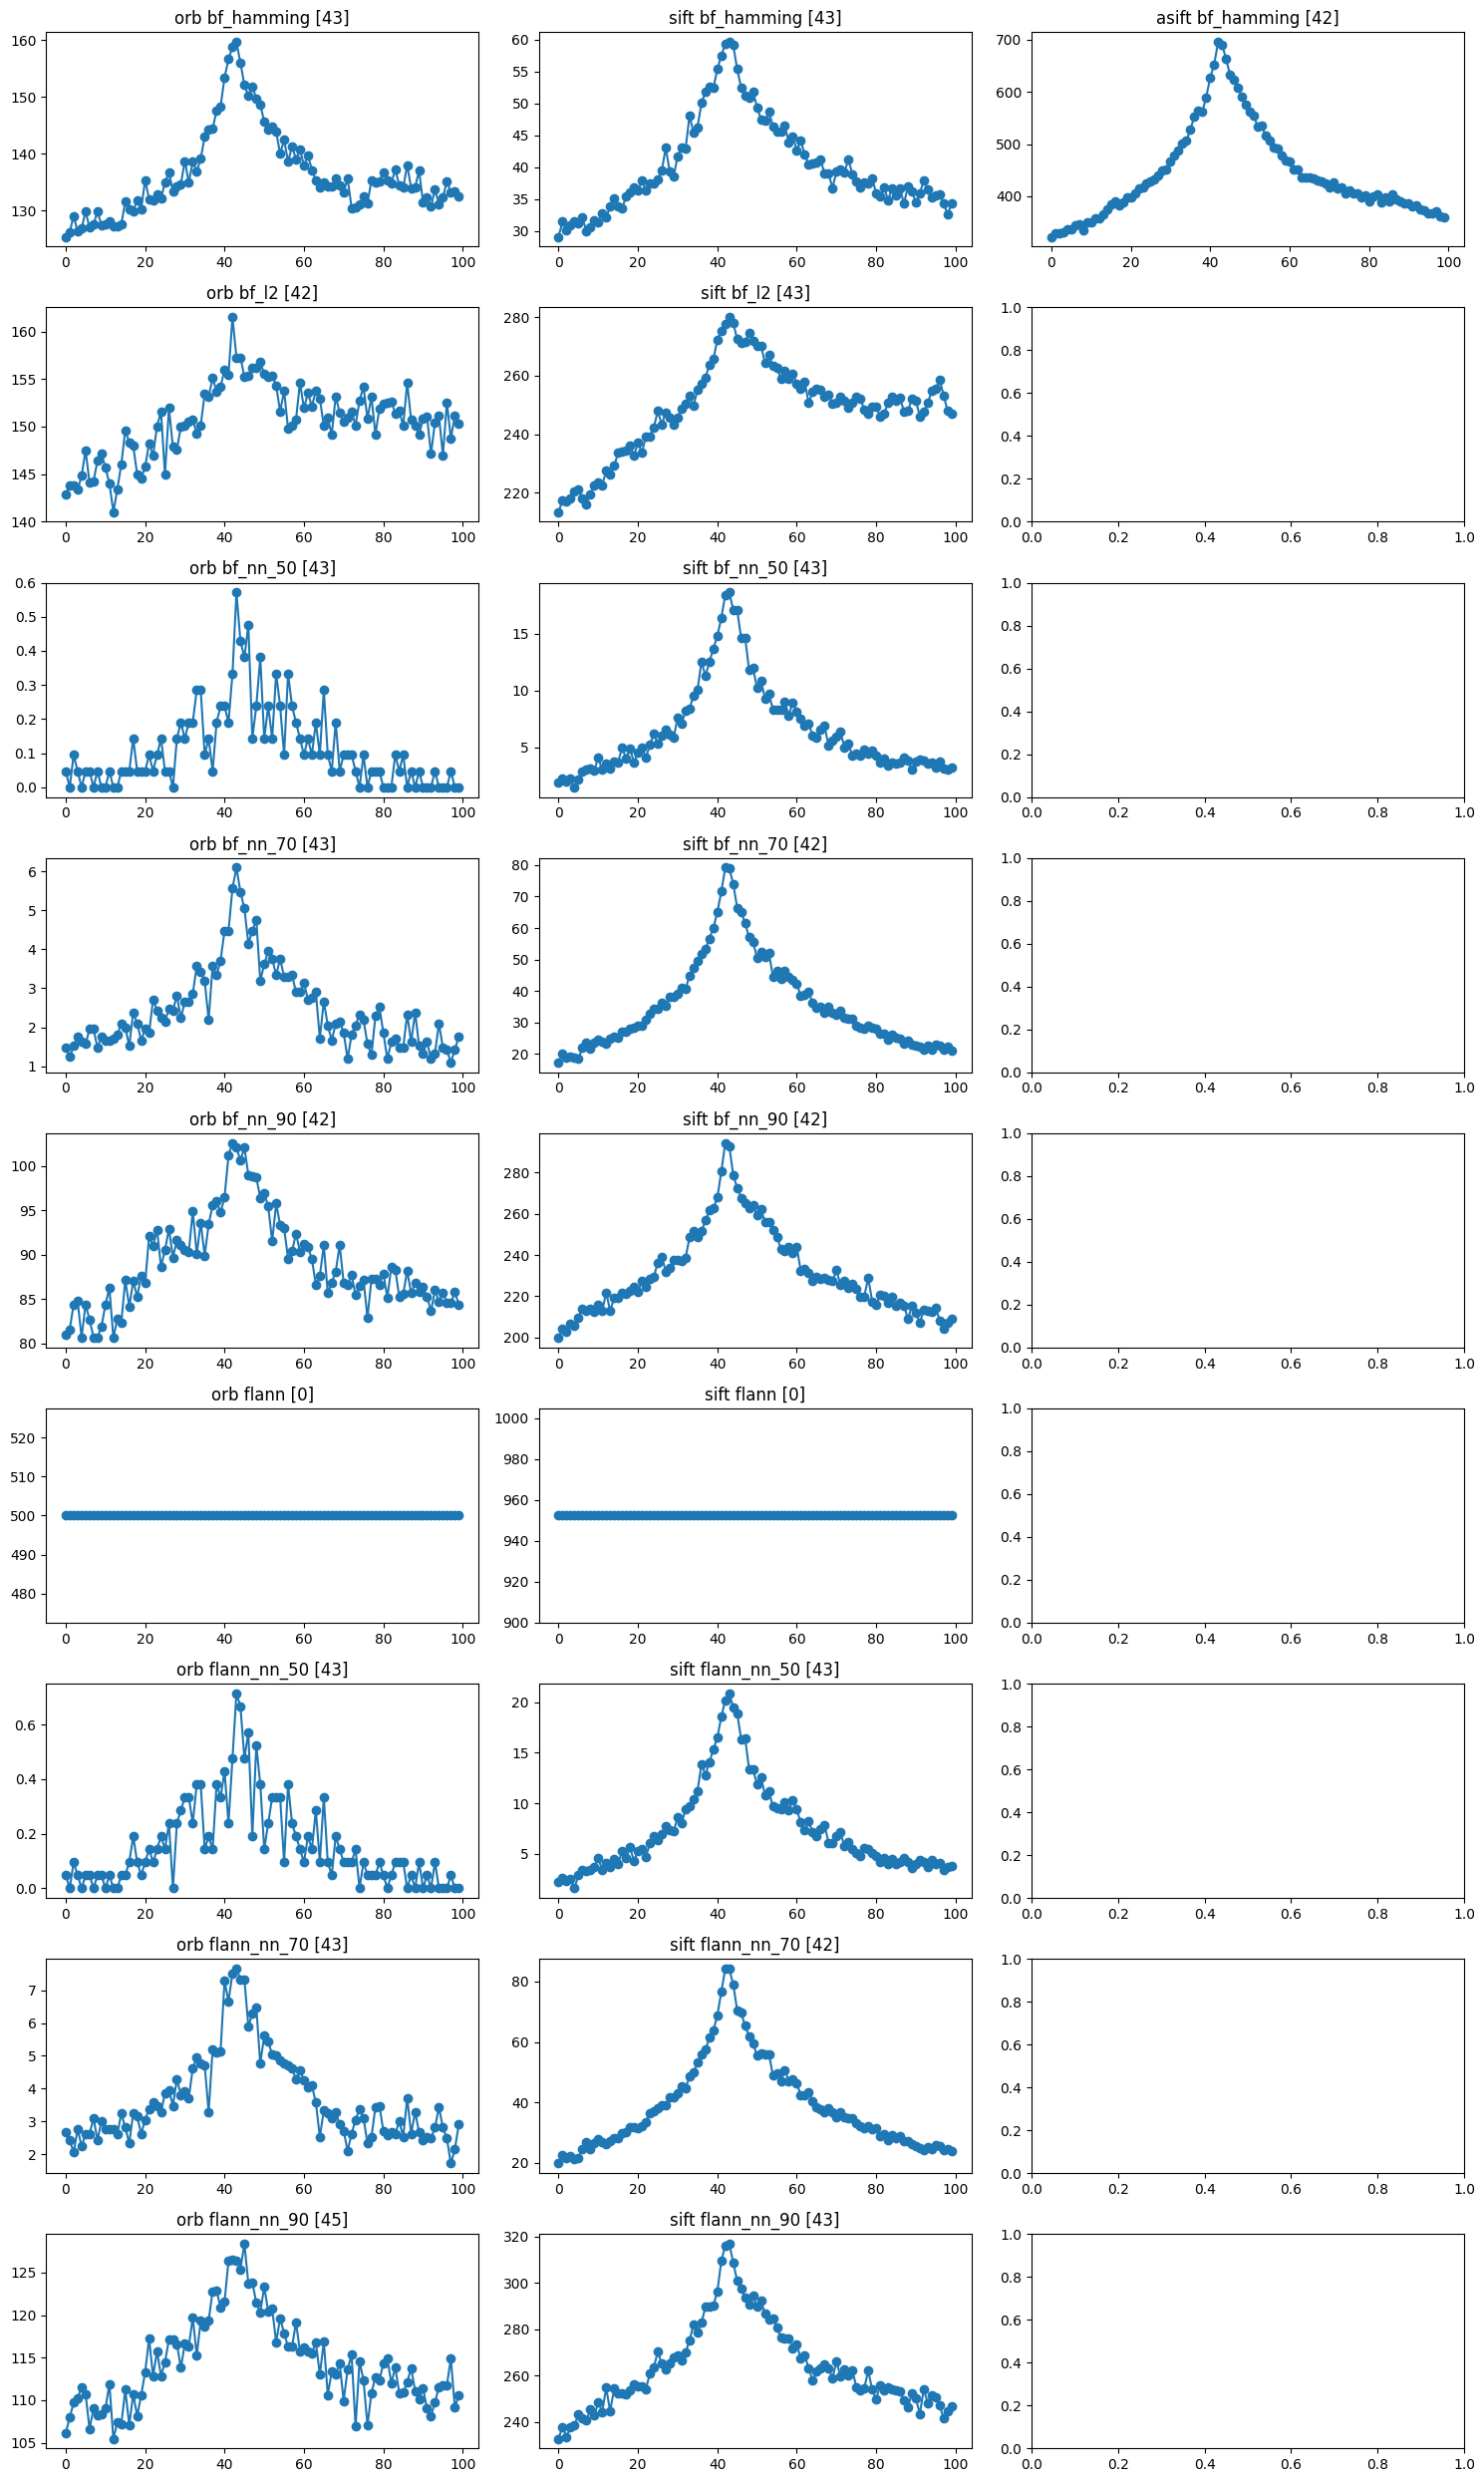

In [ ]:
fig, axs = plt.subplots(len(matchers), len(feature_extractors), figsize=(15, 25))
for i, matcher_name in enumerate(matchers.keys()):
    for j, fe_name in enumerate(feature_extractors.keys()):
        ax = axs[i, j]
        res = result.get((fe_name, matcher_name))
        if res is None:
            continue
        mean_res = np.mean(res, axis=1)
        best_idx = np.argmax(mean_res)
        ax.plot(mean_res, "o-")
        ax.set_title(f"{fe_name} {matcher_name} [{best_idx}]")

plt.tight_layout()
plt.show()

In [ ]:
j

9

In [ ]:
new_match_means = np.mean(all_matches, axis=1)
opt_offset = np.argmax([np.mean(matches) for matches in all_matches])

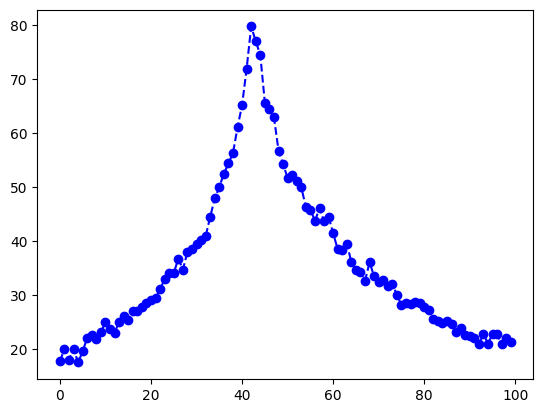

In [ ]:
plt.plot(np.mean(all_matches, axis=1), "bo--")

In [ ]:
opt_offset * window_length - src_offset

-4

In [ ]:
@dataclasses.dataclass
class StripSpec:
    mask: np.ndarray
    homography: np.ndarray
    matches: int

    @property
    def inv_homography(self) -> np.ndarray:
        return np.linalg.inv(self.homography)


def refine_homography(
    src_frame: np.ndarray, event_frame_gs: np.ndarray, num_strips: int
) -> tuple[StripSpec]:
    overlap_masks = utils.make_horiz_masks(
        num_strips, src_frame.shape[1], src_frame.shape[0], 120
    )
    masks = utils.make_horiz_masks(num_strips, src_frame.shape[1], src_frame.shape[0])
    src_frame_gs = cv2.cvtColor(src_frame, cv2.COLOR_BGR2GRAY)
    event_frame_gs_gb = cv2.GaussianBlur(event_frame_gs, (0, 0), 3)
    event_frame_gs = cv2.addWeighted(event_frame_gs, 1.5, event_frame_gs_gb, -0.5, 0)

    alg = cv2.AffineFeature.create(cv2.SIFT.create())
    matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    specs = []
    for o_mask, mask in zip(overlap_masks, masks):
        kp1, des1 = alg.detectAndCompute(src_frame_gs, o_mask)
        kp2, des2 = alg.detectAndCompute(event_frame_gs, o_mask)
        matches = matcher.match(des1, des2)
        assert len(matches) > 0, "No matches found"
        src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
        H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        specs.append(StripSpec(mask, H, len(matches)))
    return specs


def show_refinement_result(event_frame_gs: np.ndarray, specs: list[StripSpec]):
    full = np.zeros_like(event_frame_gs)
    fig, ax = plt.subplots(1, len(specs) + 2, figsize=((len(specs) + 2) * 5, 5))
    ax[0].imshow(event_frame_gs, cmap="gray")
    for i, spec in enumerate(specs):
        warped = cv2.warpPerspective(
            event_frame_gs, spec.inv_homography, (full.shape[1], full.shape[0])
        )
        full[spec.mask > 0] = warped[spec.mask > 0]
        ax[i + 1].imshow(warped, cmap="gray")
    ax[-1].imshow(full, cmap="gray")
    plt.show()

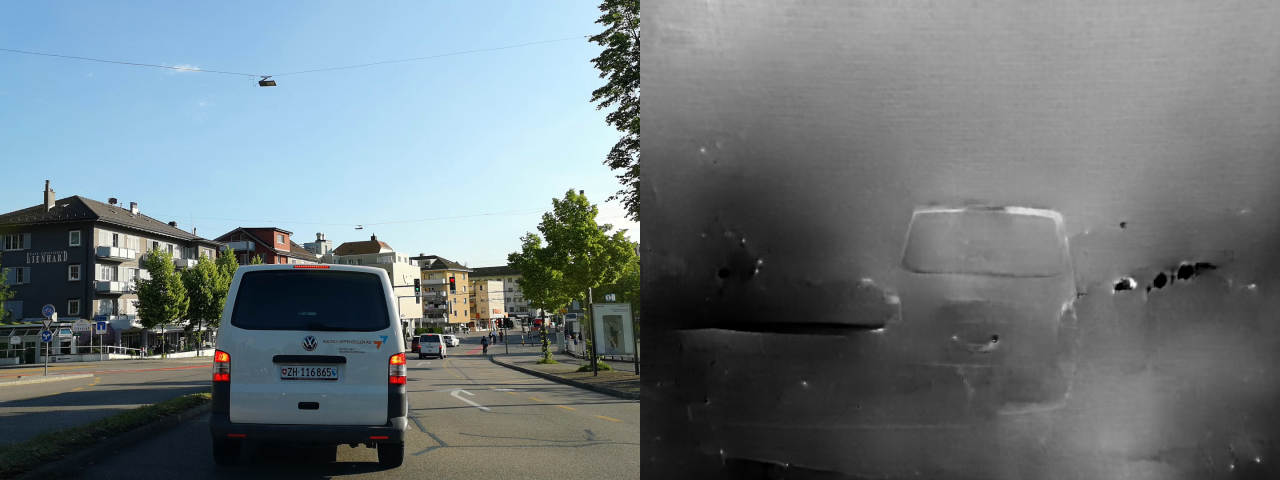

In [ ]:
showarray(
    np.hstack([src_frames.array[0], cv2.cvtColor(rec_frames[60], cv2.COLOR_GRAY2BGR)])
)

In [ ]:
specs = []
for src_idx, rec_idx in tqdm.tqdm(align_idices[opt_offset]):
    src_frame_gs = cv2.cvtColor(src_frames.array[src_idx], cv2.COLOR_BGR2GRAY)
    rec_frame = rec_frames[rec_idx]
    spec = refine_homography(src_frames.array[src_idx], rec_frame, 4)
    specs.append(spec)

100%|██████████| 21/21 [03:46<00:00, 10.78s/it]


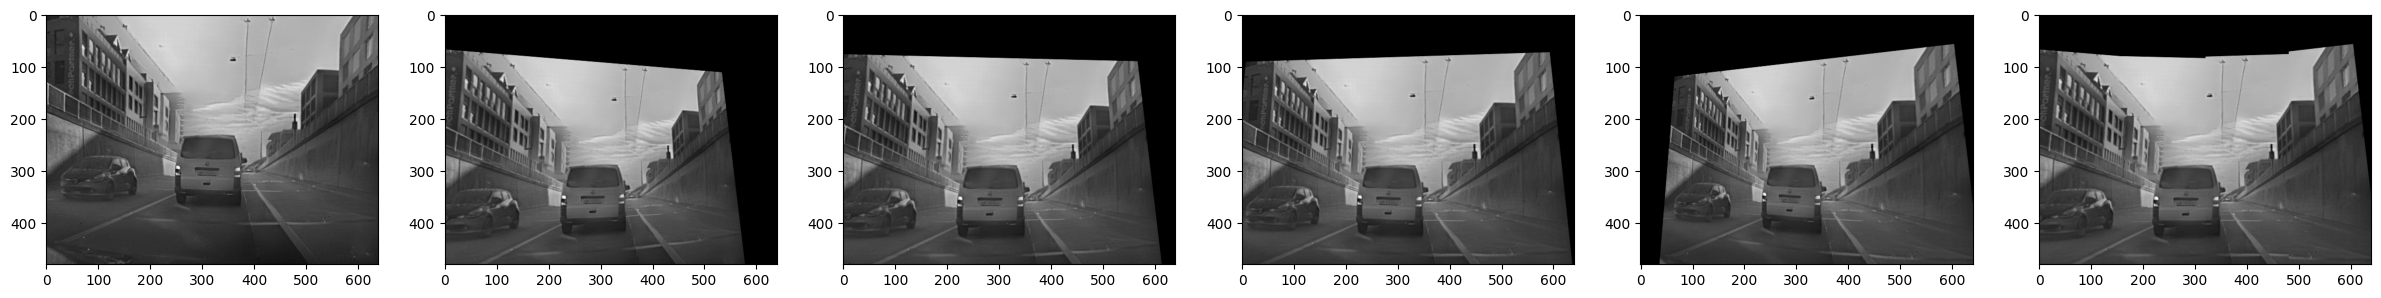

In [ ]:
# best_homs = [
#     specs[np.argmax([s[i].matches for s in specs])][i] for i in range(len(specs[0]))
# ]
best_homs = specs[np.argmax([sum(s.matches for s in spec) for spec in specs])]
show_refinement_result(rec_frames[rec_idx], best_homs)

In [ ]:
import mask

In [ ]:
masks = {
    d: mask.MaskGenerator(HEIGHT, WIDTH, 1, d, 10, 50)(4)
    for d in ["LIGHT", "MEDIUM", "HEAVY"]
}

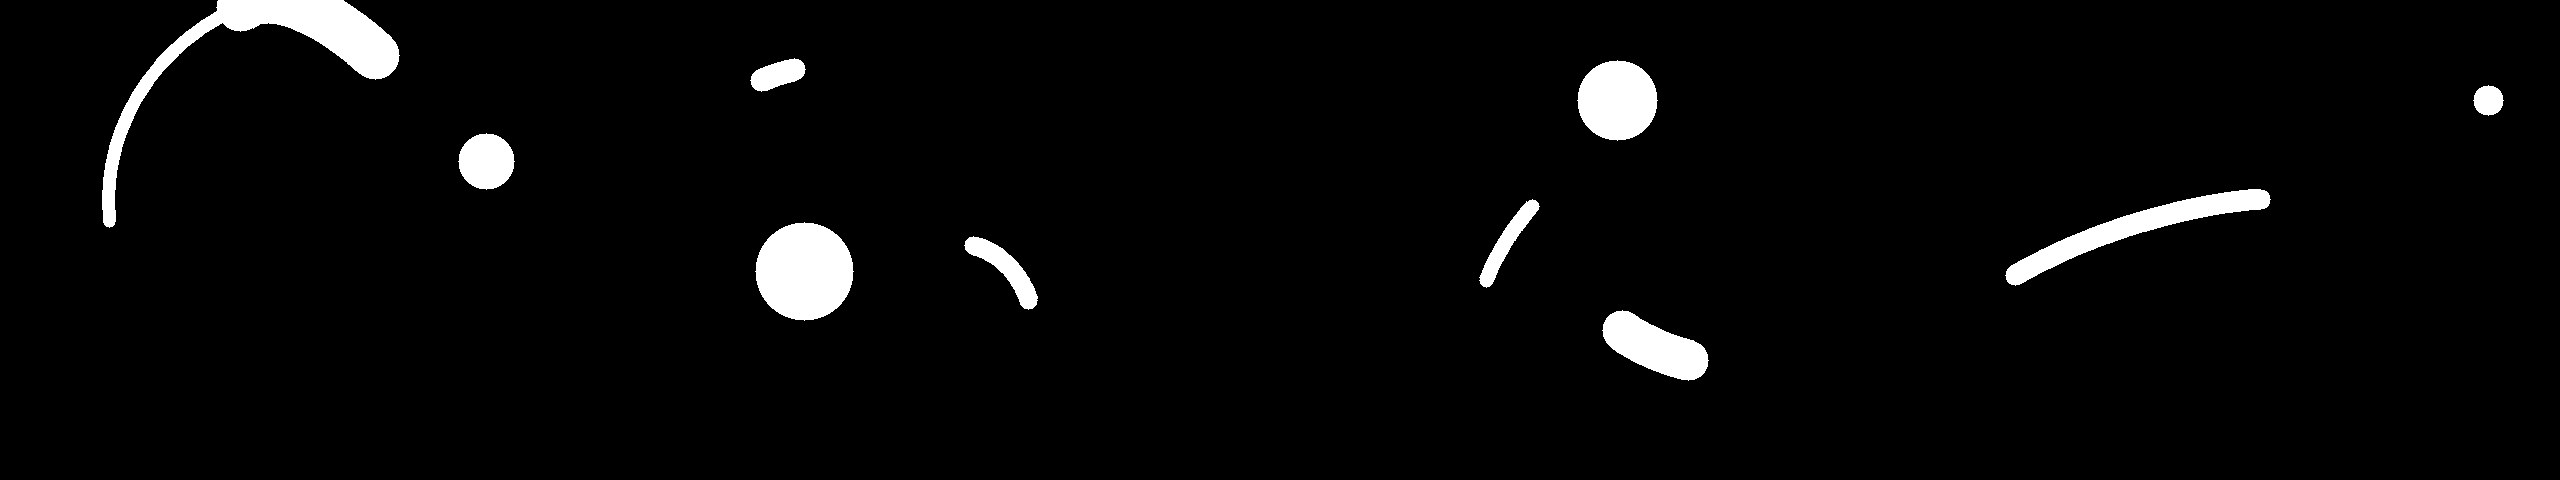

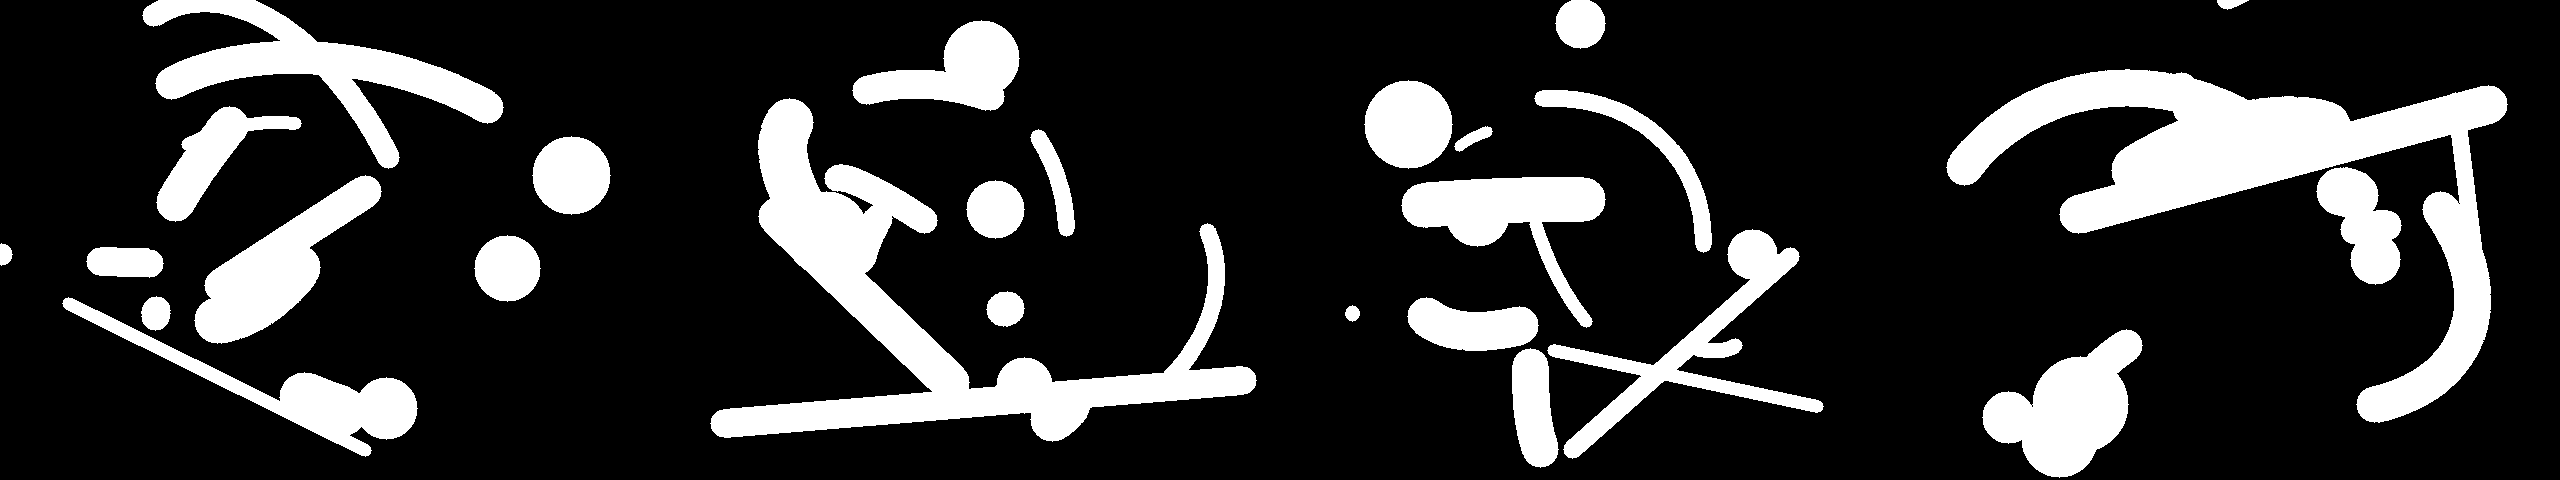

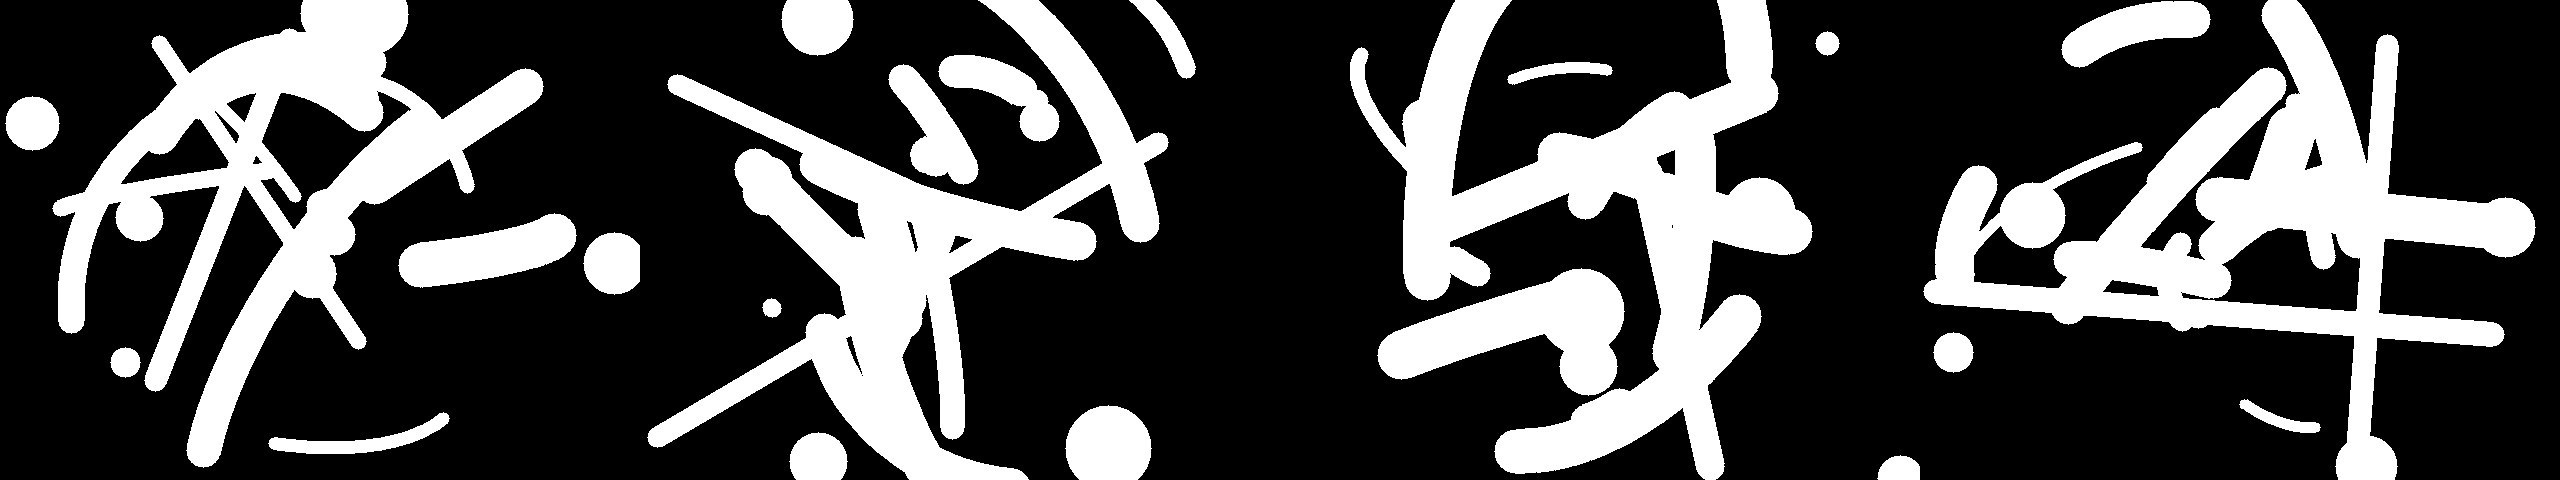

In [ ]:
for degree, m in masks.items():
    showarray(np.hstack(list(m)))